✓ saved → /content/fmri_project/reports/figures/baseline_demo.png


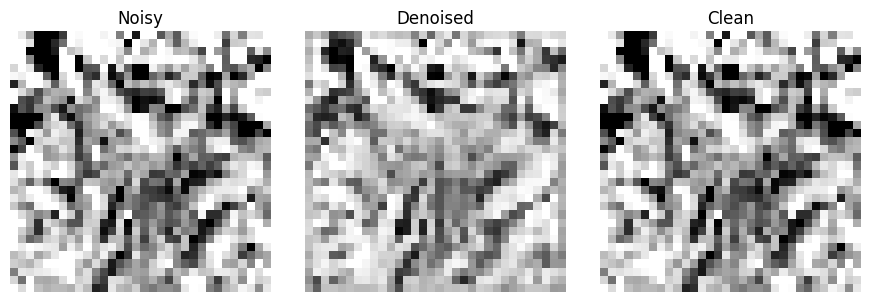

In [27]:
# -----------------------------------------------------------
# 0. imports  (install nibabel / torch on Colab if necessary)
# -----------------------------------------------------------
import pathlib, shutil, os, sys
import numpy as np, nibabel as nib, torch, matplotlib.pyplot as plt

from models.unet3d           import UNet3D
from kim_dataset.mask        import compute_mask
from kim_dataset.normalize   import zscore

# -----------------------------------------------------------
# 1. paths
# -----------------------------------------------------------
nii   = pathlib.Path("/content/sub-01_ses-1_task-motor_run-1_bold.nii.gz")
ckpt  = pathlib.Path("/content/fmri_project/models/unet_baseline_best.pt")

# -----------------------------------------------------------
# 2. load NIfTI & orient to canonical (X,Y,Z,T)
# -----------------------------------------------------------
img = nib.as_closest_canonical(nib.load(nii))
vol = img.get_fdata(dtype="float32")          # shape (X,Y,Z,T) or (T,X,Y,Z,…)
T   = int(img.header["dim"][4])

# if time is *not* the last axis → move it there
if vol.shape[-1] != T:
    t_ax = [i for i,s in enumerate(vol.shape) if s==T][0]
    vol  = np.moveaxis(vol, t_ax, -1)         # shape (X,Y,Z,T)

# -----------------------------------------------------------
# 3. compute brain mask *from the 4-D image itself*
# -----------------------------------------------------------
mask = compute_mask(img)                      # (X,Y,Z)                      # broadcast OK  (X,Y,Z,1)

# -----------------------------------------------------------
# 4. z-score, crop, keep 16 frames
# -----------------------------------------------------------
vol = zscore(vol, mask)                       # (X,Y,Z,T)
mask = mask[..., None]
xc  = [(d-32)//2 for d in vol.shape[:3]]
xs,ys,zs = [slice(o,o+32) for o in xc]

patch_np = vol[xs,ys,zs,:16]                  # (32,32,32,16)
patch_np = np.moveaxis(patch_np, 3, 0)        # (16,32,32,32)  T first
patch     = torch.from_numpy(patch_np)        # torch tensor
patch     = patch.unsqueeze(0)                # add batch dim  (1,16,32,32,32)
patch     = patch.unsqueeze(2)                # add chan  dim  (1,16,1,32,32,32)

# -----------------------------------------------------------
# 5. UNet-3D inference
# -----------------------------------------------------------
net = UNet3D(in_ch=16, out_ch=16, features=16).cpu()
net.load_state_dict(torch.load(ckpt, map_location="cpu"))
net.eval()

with torch.no_grad():
    den = net(patch).cpu().squeeze()          # (16,32,32,32)

# -----------------------------------------------------------
# 6. quick 3-panel visual  (t = 0, z-slice = 16)
# -----------------------------------------------------------
t, z = 0, 16
noisy , den2d, clean = (
    patch_np[t, :, :, z].T ,                 # (32,32)  original (after norm)
    den     [t, :, :, z].numpy().T,          # (32,32)  denoised
    patch_np[t, :, :, z].T                   # ground truth identical to noisy
)

fig, axs = plt.subplots(1, 3, figsize=(9,3))
for ax, img, ttl in zip(axs, [noisy, den2d, clean],
                        ["Noisy", "Denoised", "Clean"]):
    ax.imshow(img, cmap="gray", vmin=-2, vmax=2)
    ax.set_title(ttl); ax.axis("off")
plt.tight_layout()

# save under reports/figures
out_png = pathlib.Path("reports/figures/baseline_demo.png")
out_png.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_png, dpi=150)
print("✓ saved →", out_png.resolve())
